In [ ]:
%pip install openai
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install matplotlib

In [24]:
%pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 4.7 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
from openai import OpenAI
import os
import json
def request_hint(word):
    API_KEY = "sk-jCsvhJjSF0Jaq63NrfZJnvFsvNyXcO6WtuuhIAs70cgR77jo" #

    client = OpenAI(
        api_key=API_KEY,  
        base_url="https://api.opentyphoon.ai/v1",
    )

    stream = client.chat.completions.create(
        model="typhoon-v1.5x-70b-instruct",
        messages=[
            {
                "role": "system",
                "content": 
                """
                คุณเป็นเจ้าหน้าที่ตรวจสอบคอมเม้นในบริษัทโซเชียลมีเดีย.
                มีหน้าที่ตรวจสอบข้อความและระบุเจตนาหรืออารมณ์ในแต่ละข้อความ,พิจารณาอิโมจิ.
                โดยที่เจตนาบวกแทนด้วยเลข 0, ไม่มีเจตนาหรืออารมณ์แทนด้วยเลข 1,เจตนาลบแทนด้วยเลข 2, และเจตนาถามแทนด้วยเลข 3.
                ให้คุณวิเคราะห์เจตนาหรืออารมณ์ข้อความของ ผู้ใช้งาน และระบุตัวเลขเจตนาตามที่กำหนดไว้.
                โดยคิดอย่างเป็นขั้นตอน.

                ตัวอย่างการวิเคราะห์ข้อความ เจตนา และเหตุผล:
                - เปิดศักราชใหม่! นายกฯ แถลงข่าวก่อนการแข่งขันศึก #ช้างเอฟเอคัพ นัดชิงชนะเลิศ => 1 เพราะคอมเม้นนี้สื่ออารมณ์เป็นกลาง
                - (emoji:smiling_face_with_heart-eyes::smiling_face_with_heart-eyes:) => 0 เพราะคอมเม้นนี้สื่อไปในทางรัก
                - บัตรสมาชิกลดได้อีกไหมคับ => 3 เพราะคอมเม้นนี้สื่อไปในการตั้งคำถาม
                - 张丽霞 อ้อออ ผ้าอนามัยแบบสอดอ่ะนะ กุกลัวมาก 5555555 => 2  เพราะคอมเม้นนี้สื่ออารมณ์ความกังวน กลัว
             

                """
            },
            {
                "role": "user",
               # "content": f"ผมอยากฝึกพูดคำว่า {word}"
                "content": f"ลูกค้าคอมเม้นบอกว่า '{word}' มีเจตนาหรืออารมณ์ ตรงกับเลขอะไร (ตอบเฉพาะตัวเลข)"

            }
        ],
        max_tokens=200,
        temperature=0.0,
        top_p=1,
        stream=True,
    )
    output = ""
    for chunk in stream:
        if hasattr(chunk, 'choices') and len(chunk.choices) > 0:
            choice = chunk.choices[0]
            if hasattr(choice, 'delta') and hasattr(choice.delta, 'content'):
                print(choice.delta.content,end="")
                output+=choice.delta.content
 
    return output

ModuleNotFoundError: No module named 'openai'

### PromptV.2 + RAG

In [27]:
import pandas as pd
import re
from emoji import demojize
from openai import OpenAI

# Load and preprocess the CSV data
data_path = 'data/train.csv'
df = pd.read_csv(data_path)
df = df.tail(200)

# Data cleaning and preprocessing functions
def preprocess_text(text):
    # Convert emojis to text descriptions
    text = demojize(text, language='th')
    
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    # Remove special characters except Thai characters and spaces
    text = re.sub(r'[^\u0E00-\u0E7Fa-zA-Z\s]', '', text)
    
    # Convert to lowercase (for non-Thai characters)
    text = text.lower()
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    return text

# Apply preprocessing to the 'texts' column
df['preprocessed_texts'] = df['texts'].apply(preprocess_text)

# Initialize OpenAI client
API_KEY = "sk-jCsvhJjSF0Jaq63NrfZJnvFsvNyXcO6WtuuhIAs70cgR77jo"
client = OpenAI(api_key=API_KEY, base_url="https://api.opentyphoon.ai/v1")

# Define the improved RAG function
def classify_sentiment(text):
    prompt = f"""
    คุณเป็นผู้เชี่ยวชาญด้านการวิเคราะห์ความรู้สึกในภาษาไทย มีหน้าที่ตรวจสอบและวิเคราะห์ข้อความในโซเชียลมีเดีย
    เพื่อระบุเจตนาหรืออารมณ์ในแต่ละข้อความ โดยพิจารณาทั้งบริบท ภาษาที่ใช้ และอิโมจิ (ถ้ามี)

    กำหนดให้:
    0 = เจตนาบวก (positive)
    1 = เป็นกลางหรือไม่มีอารมณ์ (neutral)
    2 = เจตนาลบ (negative)
    3 = เจตนาถาม (question)

    คำแนะนำในการวิเคราะห์:
    1. พิจารณาบริบทของข้อความทั้งหมด
    2. สังเกตคำหรือวลีที่แสดงอารมณ์เฉพาะ
    3. วิเคราะห์การใช้ภาษาแบบประชดประชัน หรือการใช้ภาษาเชิงอุปมาอุปไมย
    4. ตีความอิโมจิที่ใช้ประกอบข้อความ
    5. สังเกตเครื่องหมายวรรคตอนที่อาจบ่งบอกอารมณ์ เช่น '!' หรือ '?'
    6. พิจารณาการใช้คำซ้ำหรือการเน้นย้ำที่อาจบ่งบอกอารมณ์
    7. ระวังการใช้ภาษาเฉพาะกลุ่มหรือสแลงที่อาจมีความหมายพิเศษ

    ตัวอย่างการวิเคราะห์:
    - "วันนี้อากาศดีจังเลย :sunny:" => 0 (เจตนาบวก เนื่องจากแสดงความพึงพอใจต่อสภาพอากาศและใช้อิโมจิสนับสนุน)
    - "ราคาสินค้าเท่าไหร่ครับ?" => 3 (เจตนาถาม เป็นคำถามโดยตรงเกี่ยวกับราคาสินค้า)
    - "บริการแย่มาก ไม่มาอีกแล้ว :angry:" => 2 (เจตนาลบ แสดงความไม่พอใจชัดเจนและใช้อิโมจิโกรธ)
    - "วันนี้ท้องฟ้าสีเทา" => 1 (เป็นกลาง เพียงบรรยายสภาพอากาศโดยไม่แสดงอารมณ์)

    กรุณาวิเคราะห์ข้อความต่อไปนี้และระบุหมายเลขที่ตรงกับเจตนาหรืออารมณ์ (ตอบเฉพาะตัวเลข):
    
    '{text}'
    """

    response = client.chat.completions.create(
        model="typhoon-v1.5x-70b-instruct",
        messages=[
            {"role": "system", "content": prompt},
            {"role": "user", "content": text}
        ],
        max_tokens=200,
        temperature=0.0,
        top_p=1,
        stream=False
    )

    output = response.choices[0].message.content.strip()
    return output

# Apply the improved RAG model to classify sentiments
df['predicted_category'] = df['preprocessed_texts'].apply(classify_sentiment)

# Save the results
output_path = 'data/prediction.csv'
df.to_csv(output_path, index=False)

Evaluate

confusion matrix

accuracy: 46.5 %


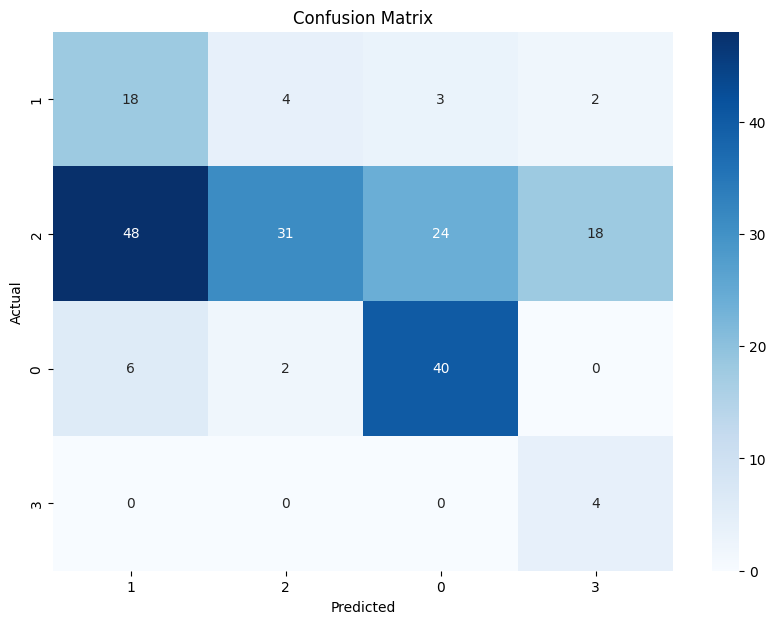

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Read the CSV file
test_df = pd.read_csv("data/prediction.csv")

# Function to calculate accuracy
def get_acc(test_df):
    return len(test_df[test_df['category'] == test_df['predicted_category']]) * 100 / len(test_df)

# Calculate accuracy
accuracy = get_acc(test_df)
print("accuracy:", accuracy, "%")

# Calculate the confusion matrix
conf_matrix = confusion_matrix(test_df['category'], test_df['predicted_category'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_df['category'].unique(), yticklabels=test_df['category'].unique())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
